In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import ast
import json
import re
style.use('seaborn-darkgrid')

In [2]:
conn = sqlite3.connect('dataBaseCDAuction.sqlite')
cur = conn.cursor()

In [3]:
NRUNS = 10

# Stock market model analysis
In this notebook, we analyse the stock market model dynamics. We focus on general market dynamics, fundamentals and trader dynamics. 

In [4]:
def transformToTimeSeries(df, var_type, seed, object_name, operation=None):
    """return time series of type, seed, object name with a possible operation"""
    queryString = 'variable_type == "{}" and seed == {} and object_name == "{}"'.format(var_type, seed, object_name)
    variables = df.query(queryString)
    total = []
    for var in variables['value']:
        var = ast.literal_eval(var)
        if operation is not None:
            var = operation(var)
        total.append(var)
    return total

## 1 Market

In [5]:
orderBookVariables = []
for seed in range(NRUNS):
    orderBookVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type, Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} 
    ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'order'
    """.format(seed), conn))

In [6]:
orderBookVariables = pd.concat(orderBookVariables)

In [7]:
set(orderBookVariables['variable_type'])

{'asks',
 'bids',
 'matched_bids',
 'matched_bids_history',
 'order_expiration',
 'stock',
 'transaction_prices',
 'transaction_prices_history',
 'transaction_volumes',
 'transaction_volumes_history',
 'unresolved_orders_history'}

In [8]:
orderBookVariables.query('variable_type == "transaction_volumes_history"').head()

,seed,period,variable_type,object_name,object_type,value
0,0,0,transaction_volumes_history,order_book_Stock of 0,order,"[5, 5, 5, 5, 3, 2, 5, 5, 5, 5, 5, 5, 5, 5, 4, ..."
1,0,1,transaction_volumes_history,order_book_Stock of 0,order,"[0, 11, 0, 0, 0, 5, 0, 0, 0, 1, 0, 1, 0, 3, 5,..."
2,0,2,transaction_volumes_history,order_book_Stock of 0,order,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,3,transaction_volumes_history,order_book_Stock of 0,order,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,4,transaction_volumes_history,order_book_Stock of 0,order,"[0, 0, 0, 0, 0, 0, 16, 0, 2, 0, 0, 0, 0, 0, 0,..."


### 1.1 Volume

In [9]:
volumes = transformToTimeSeries(orderBookVariables, 'transaction_volumes_history', 0, 'order_book_Stock of 0', operation=sum)

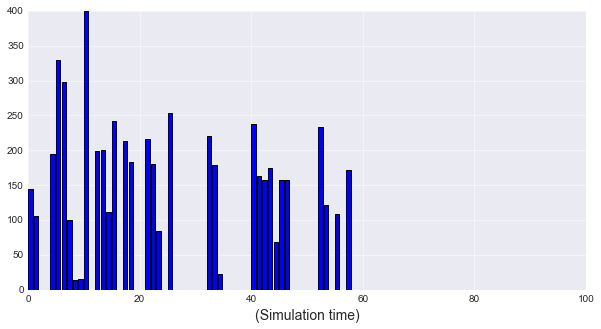

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))


ax1.bar(range(len(volumes)), volumes)


ax1.set_xlabel('(Simulation time)', fontsize='14')

#fig.savefig('tradeVolumes.png')

### 1.2 Prices

In [11]:
prices = transformToTimeSeries(orderBookVariables, 'transaction_prices_history', 0, 'order_book_Stock of 0', operation=np.mean)

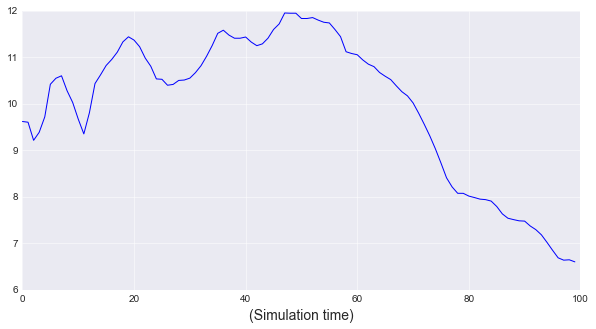

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(prices)), prices)

ax1.set_xlabel('(Simulation time)', fontsize='14')

#fig.savefig('averagePrices.png')

## 2 Fundamentals 

In [13]:
firmVariables = []
for seed in range(NRUNS):
    firmVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type, Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} 
    ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'firm'
    """.format(seed), conn))

In [14]:
firmVariables = pd.concat(firmVariables)

In [15]:
firms = {}
for seed in range(NRUNS):
    allFirms = []
    for firm in set(firmVariables['object_name']):
        allFirms.append(firmVariables.query('variable_type == "profit_history" and object_name == "{}" and seed == {}'.format(firm, seed))['value'])
    firms['run_' + str(seed)] = allFirms

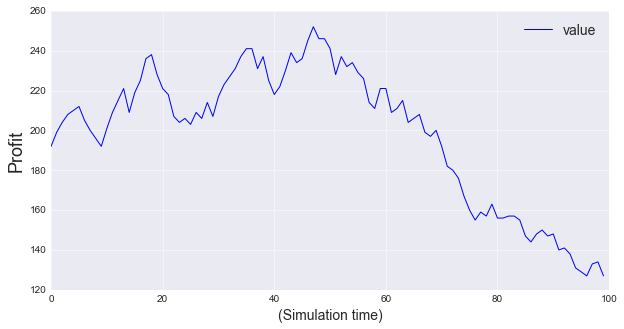

In [16]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for firm in firms['run_0']:
    ax1.plot(range(len(firm)), firm.apply(int))

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Profit', fontsize='18')

plt.legend(loc='best', fontsize='14')

## 3 Traders

In [17]:
traderVariables = []
for seed in range(NRUNS):
    traderVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type, Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} 
    ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'trader'
    """.format(seed), conn))

In [18]:
traderVariables = pd.concat(traderVariables)

In [19]:
set(traderVariables['variable_type'])

{'bid_ask_spread',
 'function',
 'function_history',
 'ma_long',
 'ma_short',
 'memory_size',
 'money',
 'money_history',
 'name',
 'portfolio_history',
 'portfolio_value_history',
 'propensity_to_switch',
 'return_on_assets',
 'stocks',
 'switching_strategy'}

In [20]:
traderVariables.head()

,seed,period,variable_type,object_name,object_type,value
0,0,0,function,trader_0,trader,<function extrapolate_average_profit at 0x0000...
1,0,0,name,trader_0,trader,0
2,0,0,bid_ask_spread,trader_0,trader,1
3,0,0,ma_long,trader_0,trader,7
4,0,0,stocks,trader_0,trader,{stock_0: 0}


## 3.1 Wealth

### 3.1.1 Money

In [21]:
traderVariables.query('variable_type == "money_history"').head()

,seed,period,variable_type,object_name,object_type,value
5,0,0,money_history,trader_0,trader,149
6,0,1,money_history,trader_0,trader,149
7,0,2,money_history,trader_0,trader,149
8,0,3,money_history,trader_0,trader,149
9,0,4,money_history,trader_0,trader,6.5395


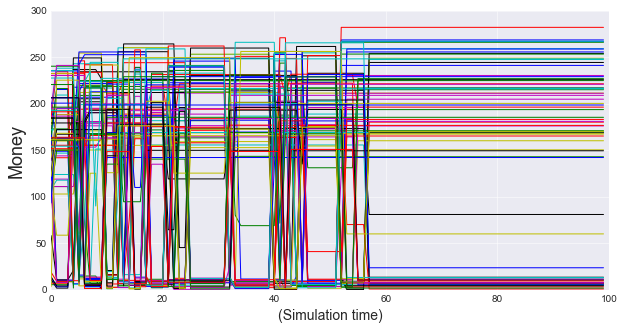

In [22]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for trader in traderVariables['object_name'].unique():
    money = traderVariables.query('variable_type == "money_history" and object_name == "{}" and seed == 0.0'.format(trader))['value']
    ax1.plot(range(len(money)), 
            money.apply(float),
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Money', fontsize='18')

### 3.1.2 Stocks

In [23]:
def transformStringToDict(stringDict):
    """This function inserts double quotation marks into the current dictionary string"""
    original = stringDict
    indis = [m.start() for m in re.finditer('stock_', original)]
    s = original
    counter = 0
    for ix in indis:
        ix = ix + counter
        s = s[:ix] + '"' + s[ix:]
        counter += 1
    dubbelPunten = [m.start() for m in re.finditer(':', original)]
    counter2 = 0
    for ix2 in dubbelPunten:
        ix2 = ix2 + counter2
        s = s[:(ix2+1)] + '"' + s[(ix2+1):]
        counter2 += 2
    d = json.loads(s)
    return d

In [24]:
traderPortfolios = traderVariables.query('variable_type == "portfolio_history"')
traderPortfolios['value'] = traderPortfolios['value'].apply(transformStringToDict)

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
uniqueStocks = [key for key in list(traderPortfolios['value'])[0]]
stocks = {}
for stock in uniqueStocks:
    stocks[stock] = []
    for i in range(len(traderPortfolios)):
        stocks[stock].append(traderPortfolios['value'].iloc[i][stock])
    traderPortfolios[stock] = stocks[stock]
#traderPortfolios.head()

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


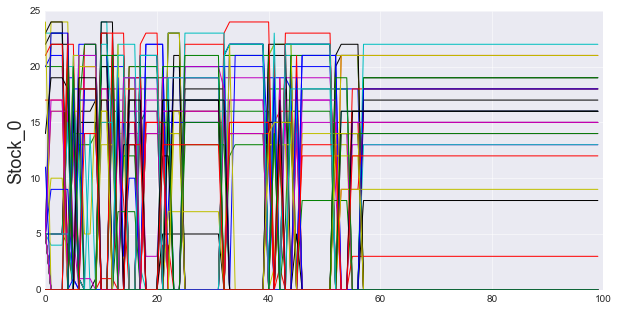

In [26]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

seed = 0

for trader in traderPortfolios['object_name'].unique():
    portfolio = traderPortfolios.query('object_name == "{}" and seed == {}'.format(trader, seed))['stock_0']
    ax1.plot(range(len(portfolio)), 
            portfolio,
            label=trader)
    
ax1.set_ylabel('Stock_0', fontsize='18')

In [27]:
traderVariables.query('variable_type == "portfolio_value_history"').head()

,seed,period,variable_type,object_name,object_type,value
311,0,0,portfolio_value_history,trader_0,trader,48.1056
312,0,1,portfolio_value_history,trader_0,trader,47.045
313,0,2,portfolio_value_history,trader_0,trader,47.045
314,0,3,portfolio_value_history,trader_0,trader,47.045
315,0,4,portfolio_value_history,trader_0,trader,193.913


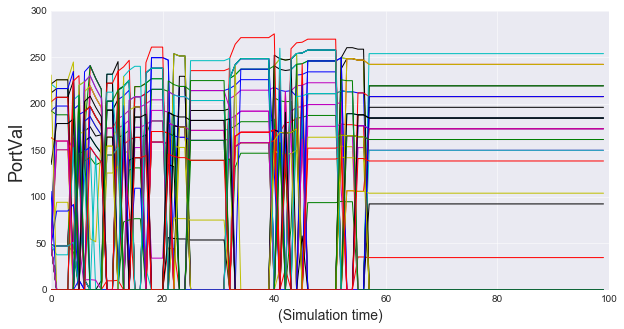

In [28]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for trader in traderVariables['object_name'].unique():
    val = traderVariables.query('variable_type == "portfolio_value_history" and object_name == "{}" and seed == 0.0'.format(trader))['value']
    ax1.plot(range(len(val)), 
            val.apply(float),
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('PortVal', fontsize='18')

## 3.2 Strategies

In [29]:
set(traderVariables['variable_type'])

{'bid_ask_spread',
 'function',
 'function_history',
 'ma_long',
 'ma_short',
 'memory_size',
 'money',
 'money_history',
 'name',
 'portfolio_history',
 'portfolio_value_history',
 'propensity_to_switch',
 'return_on_assets',
 'stocks',
 'switching_strategy'}

In [30]:
traderVariables.query('variable_type == "function_history"').tail()

,seed,period,variable_type,object_name,object_type,value
32671,9,95,function_history,trader_79,trader,<function predict_by_moving_avg_growth at 0x00...
32672,9,96,function_history,trader_79,trader,<function predict_by_moving_avg_growth at 0x00...
32673,9,97,function_history,trader_79,trader,<function predict_by_moving_avg_growth at 0x00...
32674,9,98,function_history,trader_79,trader,<function predict_by_moving_avg_growth at 0x00...
32675,9,99,function_history,trader_79,trader,<function predict_by_moving_avg_growth at 0x00...


In [31]:
set(traderVariables.query('variable_type == "function_history"')['value'])

{'<function extrapolate_average_profit at 0x00000141C0A8D950>',
 '<function predict_by_moving_avg_growth at 0x00000141C0A95158>'}

In [53]:
# calculate percentage fundamentalists for one period
def percentageFundamentalist(df, seed, period):
    fundamentalists = 0
    queryString = 'variable_type == "function_history" and seed == {0} and period == {1}'.format(seed, period)
    series = df.query(queryString)['value']
    for element in series:
        if 'average_profit' in element:
            fundamentalists += 1
    return fundamentalists / (len(series))


#fundamentalists / len(traderVariables.query('variable_type == "function_history" and seed == 0 and period == 1')['value'])

In [55]:
percFund = []
for period in range(100):
    percFund.append(percentageFundamentalist(traderVariables, 0, period))

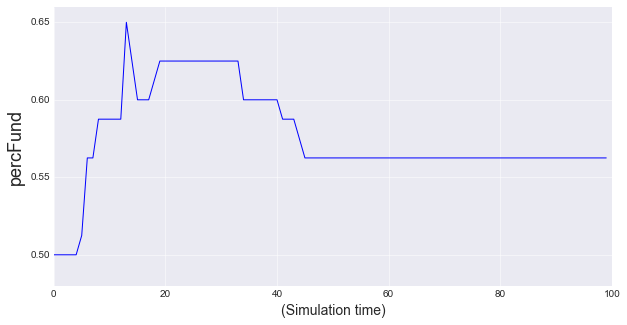

In [58]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax1.plot(range(len(percFund)), percFund)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('percFund', fontsize='18')